In [1]:
!pip install tf-nightly-2.0-preview


ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


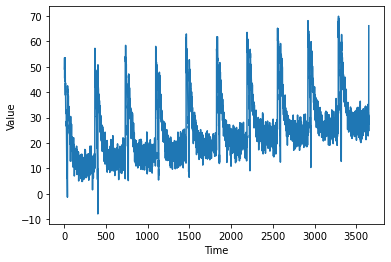

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape = [window_size], activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(6e-4))
model.fit(dataset, epochs=100)


Epoch 1/100
94/94 [==============================] - 2s 17ms/step - loss: 5.4135
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 3.9250
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 3.6490
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 3.5346
Epoch 5/100
94/94 [==============================] - 0s 5ms/step - loss: 3.4270
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 3.3298
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 3.2743
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 3.2384
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 3.1899
Epoch 10/100
94/94 [==============================] - 2s 22ms/step - loss: 3.1631
Epoch 11/100
94/94 [==============================] - 2s 17ms/step - loss: 3.1296
Epoch 12/100
94/94 [==============================] - 0s 5ms/step - loss: 3.1309
Epoch 13/100
94/94 [==============

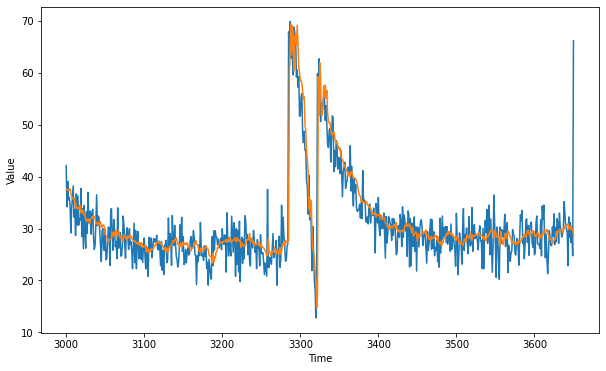

In [6]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

2.9387589